<a href="https://colab.research.google.com/github/novoforce/Exploring-Pytorch/blob/master/2_image_data_modelling_cifar_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This cell is a helper function for printing out the logs of the training
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
#The environment variable os needs to be changed when pytorch and matplotlib run in jupyter on the mac system
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 
printbar()


================================================================================2020-09-26 11:49:00


In [2]:
cd ..

/


In [3]:
#so basically I'm cloning this awesome repo which contains the dataset 
!git clone https://github.com/lyhue1991/eat_pytorch_in_20_days.git
cd eat_pytorch_in_20_days

Cloning into 'eat_pytorch_in_20_days'...
remote: Enumerating objects: 37226, done.
remote: Total 37226 (delta 0), reused 0 (delta 0), pack-reused 37226
Receiving objects: 100% (37226/37226), 39.05 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (13299/13299), done.
Checking out files: 100% (37157/37157), done.


In [4]:
!pip install torchkeras

## One, prepare the data
The cifar2 data set is a subset of the cifar10 data set, which only includes the first two categories airplane and automobile.

The training set has 5000 airplane and automobile pictures each, and the test set has 1000 airplane and automobile pictures each.

The goal of the cifar2 mission is to train a model to classify images of airplanes and automobiles.

The folder structure of the CIFAR-2 data set we prepared is shown below.

**`CIFAR-2`**

|

*   ---------->`TRAIN`
  *   ---------->`0_AIRPLANE`
       *   ---------->`img-0,img-1,img-2...`
  *   ---------->`1_AUTOMOBILE`
       *   ---------->`img-0,img-1,img-2...`
   

*   ---------->`TEST`
  *   ---------->`0_AIRPLANE`
       *   ---------->`img-0,img-1,img-2...`
  *   ---------->`1_AUTOMOBILE`
       *   ---------->`img-0,img-1,img-2...`




There are usually three ways to build a picture data pipeline in Pytorch.

The first is to use datasets.ImageFolder in torchvision to read images and then use DataLoader to load them in parallel.

The second is to implement user-defined reading logic by inheriting torch.utils.data.Dataset and then use DataLoader to load in parallel.

The third method is a general method for reading user-defined data sets, which can read image data sets or text data sets.

In this article, we introduce the first method.

In [5]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 

In [6]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

In [13]:
ds_train = datasets.ImageFolder("./data/cifar2/train/",transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/train/",transform = transform_valid,target_transform= lambda t:torch.tensor([t]).float())
print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [14]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

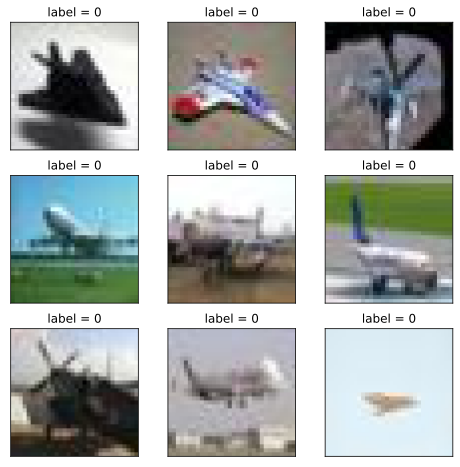

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [17]:
# The default order of Pytorch's pictures is Batch, Channel, Width, Height 
for x,y in dl_train:
    print(x.shape,y.shape) 
    break
    

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


# Second, define the model
There are usually three ways to build a model using Pytorch:
*  use **nn.Sequential** to build a model in layer order,
*  inherit **nn.Module** base class to build a custom model, 
* inherit **nn.Module** base class to build a model and assist in applying model containers (nn.Sequential, nn. ModuleList, nn.ModuleDict) is encapsulated.

Here choose to build a custom model by inheriting the nn.Module base class.

In [18]:
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [28]:
help(Net)

Help on class Net in module __main__:

class Net(torch.nn.modules.module.Module)
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  Method resolution order:
 |      Net
 |      torch.nn.modules.module.Module
 |      builtins.object
 | 

In [25]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

# Three, training model
Pytorch usually requires users to write custom training loops, and the code style of training loops varies from person to person.

There are three typical training loop code styles: 
* script form training loop, 
* function form training loop,
* class form training loop.

Here is a more general functional training loop.

In [29]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"

In [30]:
def train_step(model,features,labels):
    
    # Training mode, the dropout layer takes effect
    model.train()
    
    # Gradient clear
    model.optimizer.zero_grad()
    
    # Forward propagation for loss
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # Backpropagation gradient seek 
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # prediction mode, dropout layer does not play a role
    model.eval()
    # Turn off gradient calculation
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# next train_step
features,labels = next(iter(dl_train))
# Running a single train step
train_step(model,features,labels)

(0.6841493248939514, 0.6078098471986417)

In [32]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1,epochs+1):  

      # 1 training cycle-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # Gradient clearing
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，Eval mode for validation-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，record logs-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # epoch-level print log
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    
    return dfhistory

In [33]:
epochs = 20

dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)

Start Training...
================================================================================2020-09-26 12:34:17
[step = 50] loss: 0.689, auc: 0.708
[step = 100] loss: 0.686, auc: 0.731
[step = 150] loss: 0.683, auc: 0.750
[step = 200] loss: 0.680, auc: 0.761

EPOCH = 1, loss = 0.680,auc  = 0.761, val_loss = 0.668, val_auc = 0.805

================================================================================2020-09-26 12:34:41
[step = 50] loss: 0.665, auc: 0.788
[step = 100] loss: 0.661, auc: 0.795
[step = 150] loss: 0.656, auc: 0.796
[step = 200] loss: 0.651, auc: 0.795

EPOCH = 2, loss = 0.651,auc  = 0.795, val_loss = 0.627, val_auc = 0.808

================================================================================2020-09-26 12:35:06
[step = 50] loss: 0.620, auc: 0.795
[step = 100] loss: 0.613, auc: 0.805
[step = 150] loss: 0.608, auc: 0.801
[step = 200] loss: 0.600, auc: 0.802

EPOCH = 3, loss = 0.600,auc  = 0.802, val_loss = 0.568, val_auc = 0.811

===================

# Four, evaluation model
We first evaluate the effect of the model on the training set and validation set.

In [34]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.680459,0.760806,0.667771,0.804766
1,2.0,0.651275,0.794604,0.626957,0.808204
2,3.0,0.600041,0.802242,0.568256,0.810869
3,4.0,0.550297,0.807997,0.529548,0.818655
4,5.0,0.524518,0.816810,0.508594,0.829007
5,6.0,0.511129,0.825424,0.496109,0.838631
6,7.0,0.498522,0.834996,0.485604,0.845403
7,8.0,0.489412,0.842103,0.479277,0.850793
8,9.0,0.481688,0.850593,0.472460,0.857347
9,10.0,0.470657,0.857201,0.484907,0.867548


In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

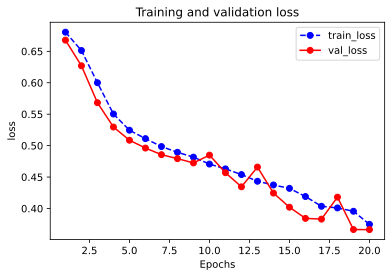

In [36]:
plot_metric(dfhistory,"loss")

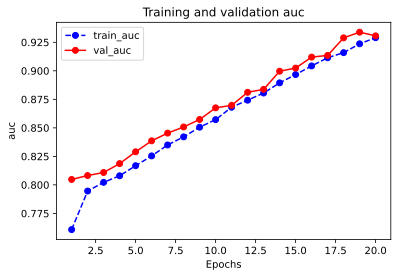

In [37]:
plot_metric(dfhistory,"auc")

# Five, use the model

In [38]:
def predict(model,dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

In [39]:
y_pred_probs = predict(model,dl_valid)
y_pred_probs

tensor([[0.0810],
        [0.0228],
        [0.1059],
        ...,
        [0.2594],
        [0.1037],
        [0.5198]])

In [41]:
y_pred = torch.where(y_pred_probs>0.5,torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])

# Six, save the model
It is recommended to save the Pytorch model by saving parameters.

In [42]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [43]:
torch.save(model.state_dict(), "./data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

predict(net_clone,dl_valid)

tensor([[0.8795],
        [0.1362],
        [0.0016],
        ...,
        [0.8597],
        [0.2019],
        [0.0715]])